In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
MODEL_STATE_DICT_PATH=os.getenv("MODEL_STATE_DICT_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.encoders.radcloud_encoder import RadCloudEncoder
from mmwave_model_integrator.model_runner.radcloud_runner import RadCloudRunner
from mmwave_model_integrator.decoders.radcloud_decoder import RadCloudDecoder
from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.plotting.movies_rng_az_to_pc import MovieGeneratorRngAzToPC

In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadCloud.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
dataset_name = "cpsl_drive"
dataset_path = os.path.join(DATASET_PATH,"radCloud_comp_datasets",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 385 radar samples
found 385 lidar samples
found 385 camera samples
found 385 imu (orientation only) samples
found 385imu (full data) samples
found 385 vehicle velocity samples


In [4]:
plotter = PlotterRngAzToPC()

radcloud_encoder = RadCloudEncoder(
    config_manager=cfg_manager,
    max_range_bin=64,
    num_chirps_to_encode=40,
    radar_fov_rad= [-0.87,0.87],
    range_az_num_angle_bins=64,
    power_range_dB=[60,105]
)

runner = RadCloudRunner(
    state_dict_path=MODEL_STATE_DICT_PATH,
    cuda_device="cuda:0"
)


radcloud_decoder = RadCloudDecoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(-50),np.deg2rad(50)],#[-np.pi/2 - 0.87,-np.pi/2 + 0.87],
    num_angle_bins=48
)

movie_generator = MovieGeneratorRngAzToPC(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_az_encoder=radcloud_encoder,
    model_runner=runner,
    lidar_pc_polar_decoder=radcloud_decoder,
    temp_dir_path=os.getenv("MOVIE_TEMP_DIRECTORY")
)

_ModelRunner: using GPU: cuda:0
found temp dir: /home/david/Downloads/radnav_temp_dir
clearing temp directory /home/david/Downloads/radnav_temp_dir


In [5]:
adc_cube = dataset.get_radar_data(idx=0)
rng_az_resp = radcloud_encoder.encode(adc_cube)
pred = runner.make_prediction(input=rng_az_resp)
pc = radcloud_decoder.convert_polar_to_cartesian(
    radcloud_decoder.decode(pred)
)

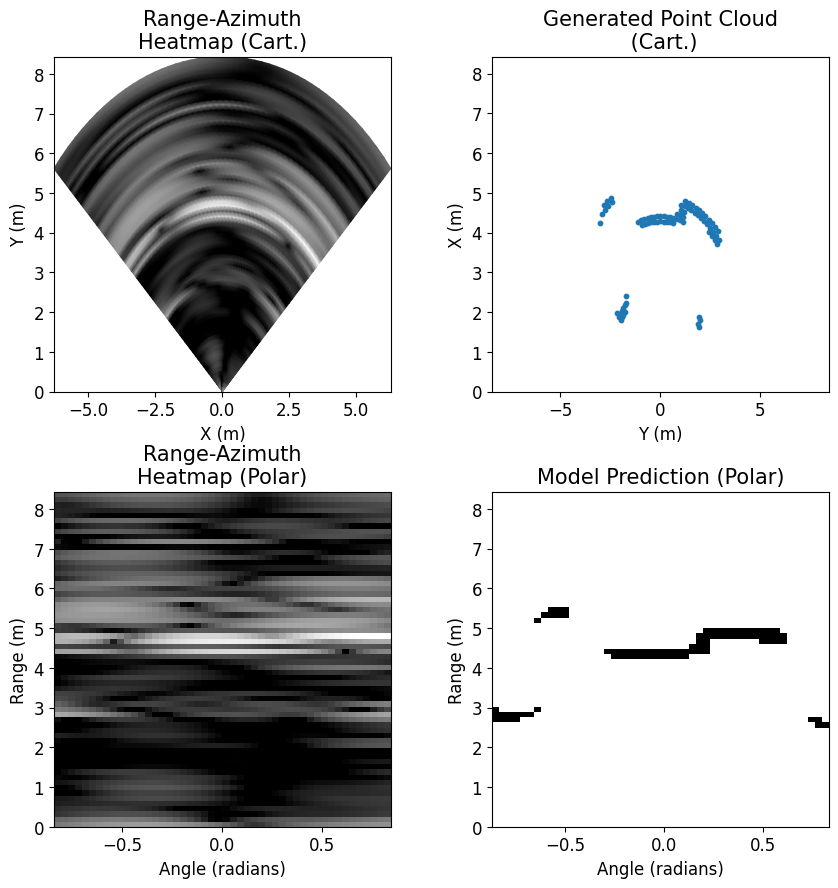

In [6]:
plotter.plot_compilation(
    adc_cube=adc_cube,
    range_az_encoder=radcloud_encoder,
    model_runner=runner,
    lidar_pc_polar_decoder=radcloud_decoder,
    chirp_idx=0,
    axs=[],
    show=True
)

  0%|          | 0/385 [00:00<?, ?it/s]

100%|██████████| 385/385 [00:14<00:00, 26.18it/s]


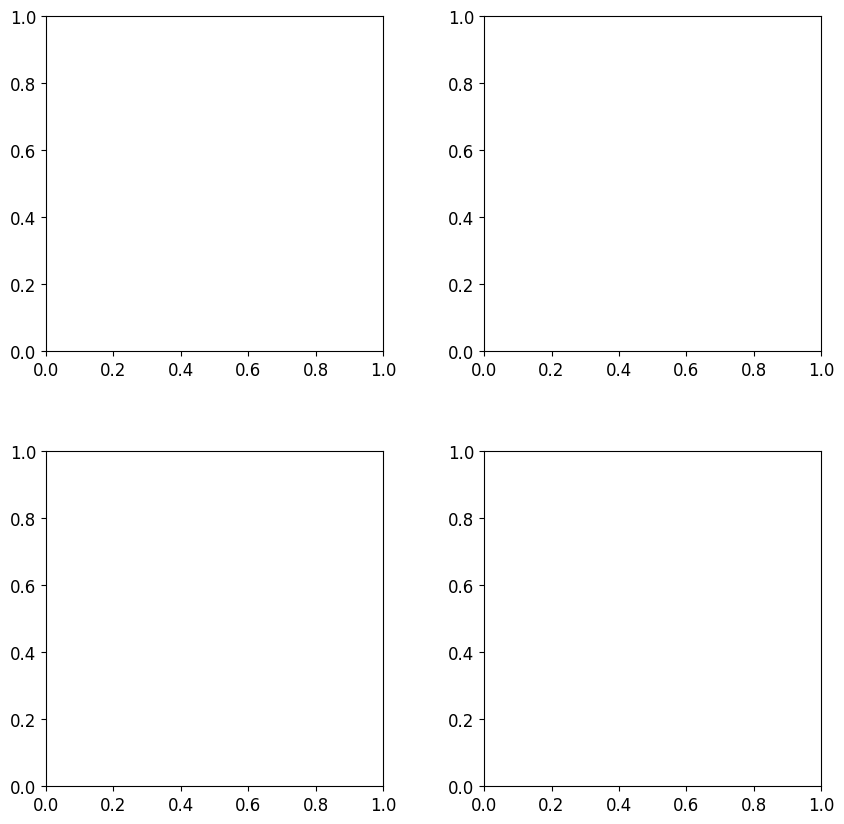

In [7]:
movie_generator.initialize_figure(
    nrows=2,
    ncols=2,
    figsize=(10,10),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames(
    chirp_idx=0
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}.mp4".format(dataset_name),fps=fps)